<a href="https://colab.research.google.com/github/dun-zhang-ca/mask-detection/blob/main/notebook1_image_process.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import time
import glob
import csv

import pandas as pd
import numpy as np

from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.preprocessing.image import img_to_array
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.neighbors import KNeighborsClassifier


import seaborn as sns
import matplotlib.pyplot as plt


In [ ]:
!pip install xmlschema

     |████████████████████████████████| 254 kB 16.1 MB/s 
     |████████████████████████████████| 149 kB 72.9 MB/s 


In [ ]:
import xmlschema

In [ ]:
DATASET1_PATH='/content/drive/My Drive/DS_DATA_PRJ4/DataSet1/'
XMLSCHEMA_FILE=DATASET1_PATH+'/annotations.xsd'
DATASET1_FACE_METADATA_CSV=DATASET1_PATH+'/dataset1_images.csv'
IMG_HEIGHT =120
IMG_WITH = 120

In [ ]:
##funtions

# Get file list from a folder,file extention default is xml 
def get_file_list(file_path,file_type='xml'):
    return [ f for f in glob.glob(str(file_path)+'*.'+file_type)]

# Get file list from a folder,file extention default is xml
def get_image_metadata_csv(file_path,csv_file,xsd_file):
    xs = xmlschema.XMLSchema(xsd_file)
    file = open(csv_file, 'w', newline ='') 
    csv_header=["filename","folder","segmented","depth","height","width",
                "object_id","xmax","xmin","ymax","ymin","difficult","name",
                "occluded","truncated"]
    data=[csv_header]

    for f in get_file_list(file_path):
        imgs=xs.to_dict(f)
        imgs_head=[ imgs["filename"],imgs["folder"],imgs["segmented"],
                    imgs["size"]["depth"],imgs["size"]["height"],
                    imgs["size"]["width"]]
        i=0
        for o in imgs["object"]:
            imgs_fact=imgs_head.copy()
            imgs_fact.append(i)
            imgs_fact.append(o["bndbox"]["xmax"])
            imgs_fact.append(o["bndbox"]["xmin"])
            imgs_fact.append(o["bndbox"]["ymax"])
            imgs_fact.append(o["bndbox"]["ymin"])
            imgs_fact.append(o["difficult"])
            imgs_fact.append(o["name"])
            imgs_fact.append(o["occluded"])
            imgs_fact.append(o["truncated"])
            data.append(imgs_fact)
            i=i+1
    with file:     
        write = csv.writer(file) 
        write.writerows(data)

def get_label(label):
    if label =='with_mask':
        return 2
    elif label == 'without_mask':
        return 0
    else:
        return 1
def get_face_mask_date(image_path, coords):
    image_obj = load_img(image_path)
    cropped_image = image_obj.crop(coords)
    newsize = (IMG_HEIGHT, IMG_WITH) 
    cropped_image=cropped_image.resize(newsize)    
#     image_array = img_to_array(cropped_image)
    return cropped_image        

In [ ]:
get_image_metadata_csv(DATASET1_PATH+'/annotations/',
                       DATASET1_FACE_METADATA_CSV,
                       XMLSCHEMA_FILE)

In [ ]:
images_metadata=pd.read_csv(DATASET1_FACE_METADATA_CSV)

data = []
labels = []
for index, row  in images_metadata.iterrows():
    label = get_label(row['name'])
    image_file=DATASET1_PATH+row['folder']+'/'+row['filename']
    image=get_face_mask_date(image_file,(row['xmin'],row['ymin'],row['xmax'],
                                         row['ymax']))
    image = img_to_array(image)
    # image = preprocess_input(image)
    data.append(image)
    labels.append(label)

In [ ]:
data = np.array(data, dtype="float32")
labels = np.array(labels)

(trainX, testX, trainY, testY) = train_test_split(data, labels,
                                                  test_size=0.20, 
                                                  stratify=labels, 
                                                  random_state=42)

In [ ]:
Xtr_new = trainX.reshape(trainX.shape[0], IMG_HEIGHT * IMG_WITH * 3) 
Xte_new = testX.reshape(testX.shape[0], IMG_HEIGHT* IMG_WITH*3)

In [ ]:
model = KNeighborsClassifier()
model.fit(Xtr_new,trainY)
ypre = model.predict(Xte_new)

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

           0       0.75      0.85      0.80       143
           1       0.00      0.00      0.00        25
           2       0.94      0.95      0.94       647

    accuracy                           0.90       815
   macro avg       0.56      0.60      0.58       815
weighted avg       0.88      0.90      0.89       815



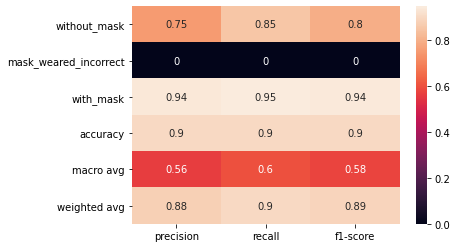

In [ ]:
print(classification_report(testY, ypre))

target_names = ['without_mask','mask_weared_incorrect','with_mask']

clf_report = classification_report(testY,
                                   ypre,
                                   target_names=target_names,
                                   output_dict=True)
sns.heatmap(pd.DataFrame(clf_report).iloc[:-1, :].T, annot=True)
plt.show()